In [1]:
from pathlib import Path

path_base = r"D:\KWork\Project 1"

file_source = Path(path_base) / "base"
train_file_destination = Path(path_base) / "data" / "train"
val_file_destination = Path(path_base) / "data" / "validation"

In [2]:
import tensorflow.keras.applications.mobilenet_v2 as mobilenet
from livelossplot.tf_keras import PlotLossesCallback
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import PIL

In [7]:
def preprocess_input_model(_image):
    from PIL import Image
    
    crop_image = _image.crop((20, 30, 110, 90))
    crop_image = crop_image.resize((128, 128), Image.ANTIALIAS)
    
    return crop_image

image = PIL.Image.open(train_file_destination / "airplane" / "airplane_1.png")
print(np.array(image))

[[[ 87 120 148 255]
  [ 85 118 146 255]
  [ 84 117 145 255]
  ...
  [ 82 113 144 255]
  [ 82 112 144 255]
  [ 81 111 145 255]]

 [[ 87 120 148 255]
  [ 85 118 146 255]
  [ 84 117 145 255]
  ...
  [ 82 113 144 255]
  [ 82 112 144 255]
  [ 81 111 145 255]]

 [[ 88 119 147 255]
  [ 87 118 146 255]
  [ 86 117 145 255]
  ...
  [ 81 112 143 255]
  [ 82 112 143 255]
  [ 82 112 144 255]]

 ...

 [[ 80  66  57 255]
  [ 81  67  58 255]
  [ 83  69  60 255]
  ...
  [ 69  55  44 255]
  [ 70  56  45 255]
  [ 72  58  47 255]]

 [[ 79  65  56 255]
  [ 80  66  57 255]
  [ 80  66  57 255]
  ...
  [ 80  66  55 255]
  [ 80  66  55 255]
  [ 81  67  57 255]]

 [[ 79  65  56 255]
  [ 78  64  55 255]
  [ 78  64  55 255]
  ...
  [ 88  74  63 255]
  [ 87  73  62 255]
  [ 87  73  63 255]]]


In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

gen_data = ImageDataGenerator(rescale=1/255.,
                              rotation_range=5,
                              width_shift_range=0.1,
                              height_shift_range=0.02,
                              zoom_range=0.15,
                              fill_mode="nearest")

In [9]:
BATCH_SIZE = 24
IMG_SHAPE = 128
IMAGE_SIZE = (128, 128, 3)

train_dir = train_file_destination
val_dir = val_file_destination

In [10]:
train_data_gen = gen_data.flow_from_directory(directory=train_dir,
                                               target_size=(IMG_SHAPE, IMG_SHAPE),
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               class_mode="sparse")

val_data_gen = gen_data.flow_from_directory(directory=val_dir,
                                           target_size=(IMG_SHAPE, IMG_SHAPE),
                                           batch_size=BATCH_SIZE,
                                           shuffle=False,
                                           class_mode="sparse")

Found 3809 images belonging to 8 classes.
Found 1629 images belonging to 8 classes.


In [11]:
train_data_gen.class_indices

{'airplane': 0,
 'bicycle': 1,
 'boat': 2,
 'bus': 3,
 'car': 4,
 'motorcycle': 5,
 'train': 6,
 'truck': 7}

In [12]:
def show_images(images):
    plt.figure(figsize=(8, 8))
    
    for i in range(0, 12):
        plt.subplot(3, 4, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i])
        plt.axis(False)
        
    plt.show()

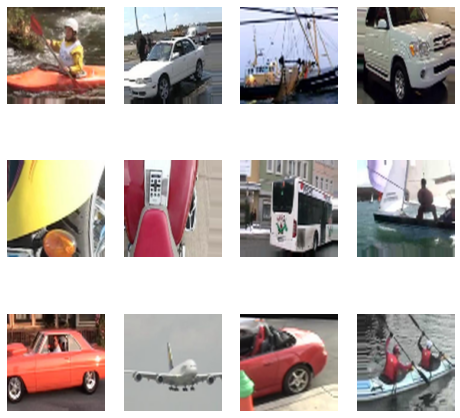

In [13]:
samples, _ = next(train_data_gen)
show_images(samples)

### Обучение модели

#### Решетчатый поиск

In [ ]:
def fit_model(model, preprocessing_func):
    EPOCHS = 30
    
    gen_data = ImageDataGenerator(preprocessing_function=preprocessing_func,
                                  rotation_range=5,
                                  width_shift_range=0.1,
                                  height_shift_range=0.02,
                                  zoom_range=0.15,
                                  fill_mode="nearest")
    
    train_data_gen = gen_data.flow_from_directory(directory=train_dir,
                                                  target_size=(IMG_SHAPE, IMG_SHAPE),
                                                  batch_size=BATCH_SIZE,
                                                  shuffle=True,
                                                  class_mode="sparse")

    val_data_gen = gen_data.flow_from_directory(directory=val_dir,
                                                target_size=(IMG_SHAPE, IMG_SHAPE),
                                                batch_size=BATCH_SIZE,
                                                shuffle=False,
                                                class_mode="sparse")
    
    base_model = model
    base_model.trainable = False

    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(8, activation="softmax")
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1.3e-4),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=["accuracy"])
    
    path = Path(f"{model.layers[0].name}")
    path.mkdir(exist_ok=True)

    filename = "best_model.hdf5"
    cpt_path = str(path / filename)
    
    
    checkpoint = tf.keras.callbacks.ModelCheckpoint(cpt_path,
                                                    monitor="val_accuracy",
                                                    verbose=1,
                                                    save_best_only=True,
                                                    mode="max")
    history = model.fit(train_data_gen,
              epochs=EPOCHS,
              validation_data=val_data_gen,
              callbacks=([PlotLossesCallback(), checkpoint]))
    
    info = f"{model.layers[0].name} - Accuracy:{max(history.history['accuracy'])} | Val_accuracy:{max(history.history['val_accuracy'])}"
    
    return info

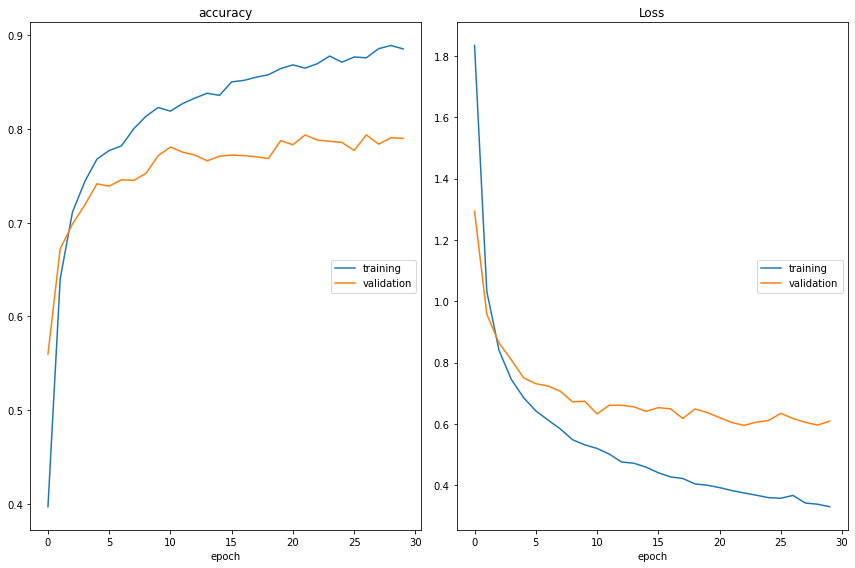

accuracy
	training         	 (min:    0.397, max:    0.889, cur:    0.886)
	validation       	 (min:    0.560, max:    0.794, cur:    0.790)
Loss
	training         	 (min:    0.330, max:    1.835, cur:    0.330)
	validation       	 (min:    0.595, max:    1.294, cur:    0.609)

Epoch 00030: val_accuracy did not improve from 0.79374


['efficientnetb7 - Accuracy:0.8566552996635437 | Val_accuracy:0.8176795840263367',
 'MobilenetV3small - Accuracy:0.8380151987075806 | Val_accuracy:0.7685696482658386',
 'resnet152v2 - Accuracy:0.8855342864990234 | Val_accuracy:0.7900552749633789']

In [12]:
models = [
    tf.keras.applications.EfficientNetB7(include_top=False,
                                         weights="imagenet",
                                         input_shape=IMAGE_SIZE),
    tf.keras.applications.MobileNetV3Small(include_top=False,
                                           weights="imagenet",
                                           input_shape=IMAGE_SIZE),
    tf.keras.applications.ResNet152V2(include_top=False,
                                      weights="imagenet",
                                      input_shape=IMAGE_SIZE)
    
]

preprocessing = [
    tf.keras.applications.efficientnet.preprocess_input,
    tf.keras.applications.mobilenet_v3.preprocess_input,
    tf.keras.applications.resnet_v2.preprocess_input
]

info = []
for n in range(len(models)):
    info.append(fit_model(models[n], preprocessing[n]))

info

#### Наиболее подходящая архитектура это EfficientNetB7